# Demand Prediction for Pakistan's Export Commodities

This notebook contains the complete forecasting pipeline for predicting export demand of Rice, Cotton Yarn, and Copper commodities.

The pipeline includes:
1. Data loading and exploratory analysis
2. Feature engineering
3. Model training (LightGBM, Prophet, SARIMAX)
4. Model evaluation and comparison
5. Future forecasting (6 months)
6. Model persistence


## Section 1: Project Setup and Data Loading



In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

# Machine learning libraries
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model persistence
import joblib
import json

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

In [3]:
# Loading  merged datasets
# Long format is used for LightGBM multi output model
# Wide format is used for Prophet and SARIMAX models

df_long = pd.read_csv('merged_export_dataset_2010_2025.csv')
df_wide = pd.read_csv('merged_export_dataset_wide_2010_2025.csv')

# Convert Date column to datetime
df_long['Date'] = pd.to_datetime(df_long['Date'])
df_wide['Date'] = pd.to_datetime(df_wide['Date'])

# Sort by date
df_long = df_long.sort_values(['Date', 'Commodity']).reset_index(drop=True)
df_wide = df_wide.sort_values('Date').reset_index(drop=True)

print("Data loaded successfully")
print(f"Long format shape: {df_long.shape}")
print(f"Wide format shape: {df_wide.shape}")
print(f"\nDate range: {df_long['Date'].min()} to {df_long['Date'].max()}")


Data loaded successfully
Long format shape: (564, 8)
Wide format shape: (188, 10)

Date range: 2010-01-01 00:00:00 to 2025-08-01 00:00:00


In [4]:
# Display first few rows of long format dataset
print("Long Format Dataset - First 10 rows:")
df_long.head(10)


Long Format Dataset - First 10 rows:


,Date,Commodity,HS_Code,Export_Value_USD,Weight_kg,USD_PKR,Oil_Price,US_Confidence
0,2010-01-01,Copper,7403,4.421384e+05,186278.0,84.304001,71.459999,74.4
1,2010-01-01,Cotton Yarn,520512,6.594636e+07,36905725.0,84.304001,71.459999,74.4
2,2010-01-01,Rice,1006,2.358505e+08,449937000.0,84.304001,71.459999,74.4
3,2010-02-01,Copper,7403,6.841989e+05,155600.0,83.324997,77.589996,73.6
4,2010-02-01,Cotton Yarn,520512,4.285944e+07,18416485.0,83.324997,77.589996,73.6
5,2010-02-01,Rice,1006,2.060461e+08,0.0,83.324997,77.589996,73.6
6,2010-03-01,Copper,7403,7.554875e+05,207147.0,83.750000,82.699997,73.6
7,2010-03-01,Cotton Yarn,520512,5.141153e+07,20400456.0,83.750000,82.699997,73.6
8,2010-03-01,Rice,1006,2.560354e+08,0.0,83.750000,82.699997,73.6
9,2010-04-01,Copper,7403,2.321051e+03,610.0,83.900002,87.440002,72.2


In [5]:
print("Long Format Dataset - Info:")
df_long.info()

Long Format Dataset - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564 entries, 0 to 563
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              564 non-null    datetime64[ns]
 1   Commodity         564 non-null    object        
 2   HS_Code           564 non-null    int64         
 3   Export_Value_USD  564 non-null    float64       
 4   Weight_kg         564 non-null    float64       
 5   USD_PKR           564 non-null    float64       
 6   Oil_Price         564 non-null    float64       
 7   US_Confidence     564 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 35.4+ KB


In [6]:
# Display first few rows of wide format dataset
print("Wide Format Dataset - First 10 rows:")
df_wide.head(10)


Wide Format Dataset - First 10 rows:


,Date,Copper_Export_Value_USD,Cotton Yarn_Export_Value_USD,Rice_Export_Value_USD,Copper_Weight_kg,Cotton Yarn_Weight_kg,Rice_Weight_kg,USD_PKR,Oil_Price,US_Confidence
0,2010-01-01,442138.359,6.594636e+07,2.358505e+08,186278.0,36905725.0,449937000.0,84.304001,71.459999,74.4
1,2010-02-01,684198.934,4.285944e+07,2.060461e+08,155600.0,18416485.0,0.0,83.324997,77.589996,73.6
2,2010-03-01,755487.484,5.141153e+07,2.560354e+08,207147.0,20400456.0,0.0,83.750000,82.699997,73.6
3,2010-04-01,2321.051,5.662788e+07,1.890975e+08,610.0,21368375.0,372348000.0,83.900002,87.440002,72.2
4,2010-05-01,42948.119,2.917664e+07,1.708859e+08,10354.0,10800696.0,348373000.0,83.967003,74.019997,73.6
5,2010-06-01,0.000,3.691923e+07,2.004378e+08,0.0,12651203.0,0.0,85.449997,75.010002,76.0
6,2010-07-01,115495.276,4.458432e+07,2.177887e+08,30600.0,15044857.0,421260000.0,85.199997,78.180000,67.8
7,2010-08-01,904401.022,5.581189e+07,1.282170e+08,240696.0,18384772.0,212558000.0,84.177002,80.244999,68.9
8,2010-09-01,4684086.499,5.434486e+07,1.271972e+08,2009987.0,18082915.0,218081000.0,86.150002,82.309998,68.2
9,2010-10-01,2898670.854,6.955054e+07,1.824195e+08,1249077.0,21566055.0,316899000.0,85.800003,83.150002,67.7


In [7]:
print("Wide Format Dataset - Info:")
df_wide.info()

Wide Format Dataset - Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          188 non-null    datetime64[ns]
 1   Copper_Export_Value_USD       188 non-null    float64       
 2   Cotton Yarn_Export_Value_USD  188 non-null    float64       
 3   Rice_Export_Value_USD         188 non-null    float64       
 4   Copper_Weight_kg              188 non-null    float64       
 5   Cotton Yarn_Weight_kg         188 non-null    float64       
 6   Rice_Weight_kg                188 non-null    float64       
 7   USD_PKR                       188 non-null    float64       
 8   Oil_Price                     188 non-null    float64       
 9   US_Confidence                 188 non-null    float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 14.8 KB


## Section 2: Exploratory Data Analysis

Let's explore the dataset to understand the data structure, distributions and relationships between variables


In [8]:
# Check for missing values
print("Missing values in long format dataset:")
print(df_long.isnull().sum())


Missing values in long format dataset:
Date                0
Commodity           0
HS_Code             0
Export_Value_USD    0
Weight_kg           0
USD_PKR             0
Oil_Price           0
US_Confidence       0
dtype: int64


In [9]:
print("Missing values in wide format dataset:")
print(df_wide.isnull().sum())

Missing values in wide format dataset:
Date                            0
Copper_Export_Value_USD         0
Cotton Yarn_Export_Value_USD    0
Rice_Export_Value_USD           0
Copper_Weight_kg                0
Cotton Yarn_Weight_kg           0
Rice_Weight_kg                  0
USD_PKR                         0
Oil_Price                       0
US_Confidence                   0
dtype: int64


In [10]:
# Basic statistics for export values by commodity
print("Export Value Statistics by Commodity (USD):")
print(df_long.groupby('Commodity')['Export_Value_USD'].describe())


Export Value Statistics by Commodity (USD):
             count          mean           std           min           25%  \
Commodity                                                                    
Copper       188.0  2.201796e+07  2.666580e+07  0.000000e+00  1.336107e+06   
Cotton Yarn  188.0  6.542952e+07  2.892687e+07  1.461666e+07  4.566145e+07   
Rice         188.0  1.897654e+08  7.162925e+07  7.548823e+07  1.426134e+08   

                      50%           75%           max  
Commodity                                              
Copper       3.396489e+06  4.138580e+07  9.469653e+07  
Cotton Yarn  6.253197e+07  8.188594e+07  1.419741e+08  
Rice         1.804980e+08  2.177958e+08  5.184698e+08  


In [11]:
# Statistics for external drivers
print("External Drivers Statistics:")
print(df_wide[['USD_PKR', 'Oil_Price', 'US_Confidence']].describe())


External Drivers Statistics:
          USD_PKR   Oil_Price  US_Confidence
count  188.000000  188.000000     188.000000
mean   148.468846   78.294096      79.842021
std     68.504622   23.651241      13.333224
min     83.324997   25.270000      50.000000
25%     99.987497   60.321250      70.050000
50%    106.650002   76.900002      78.800000
75%    170.049999  100.994999      92.700000
max    303.227112  125.889999     101.400000


## Section 3: Visualization

visualizations to understand the data patterns and relationships.


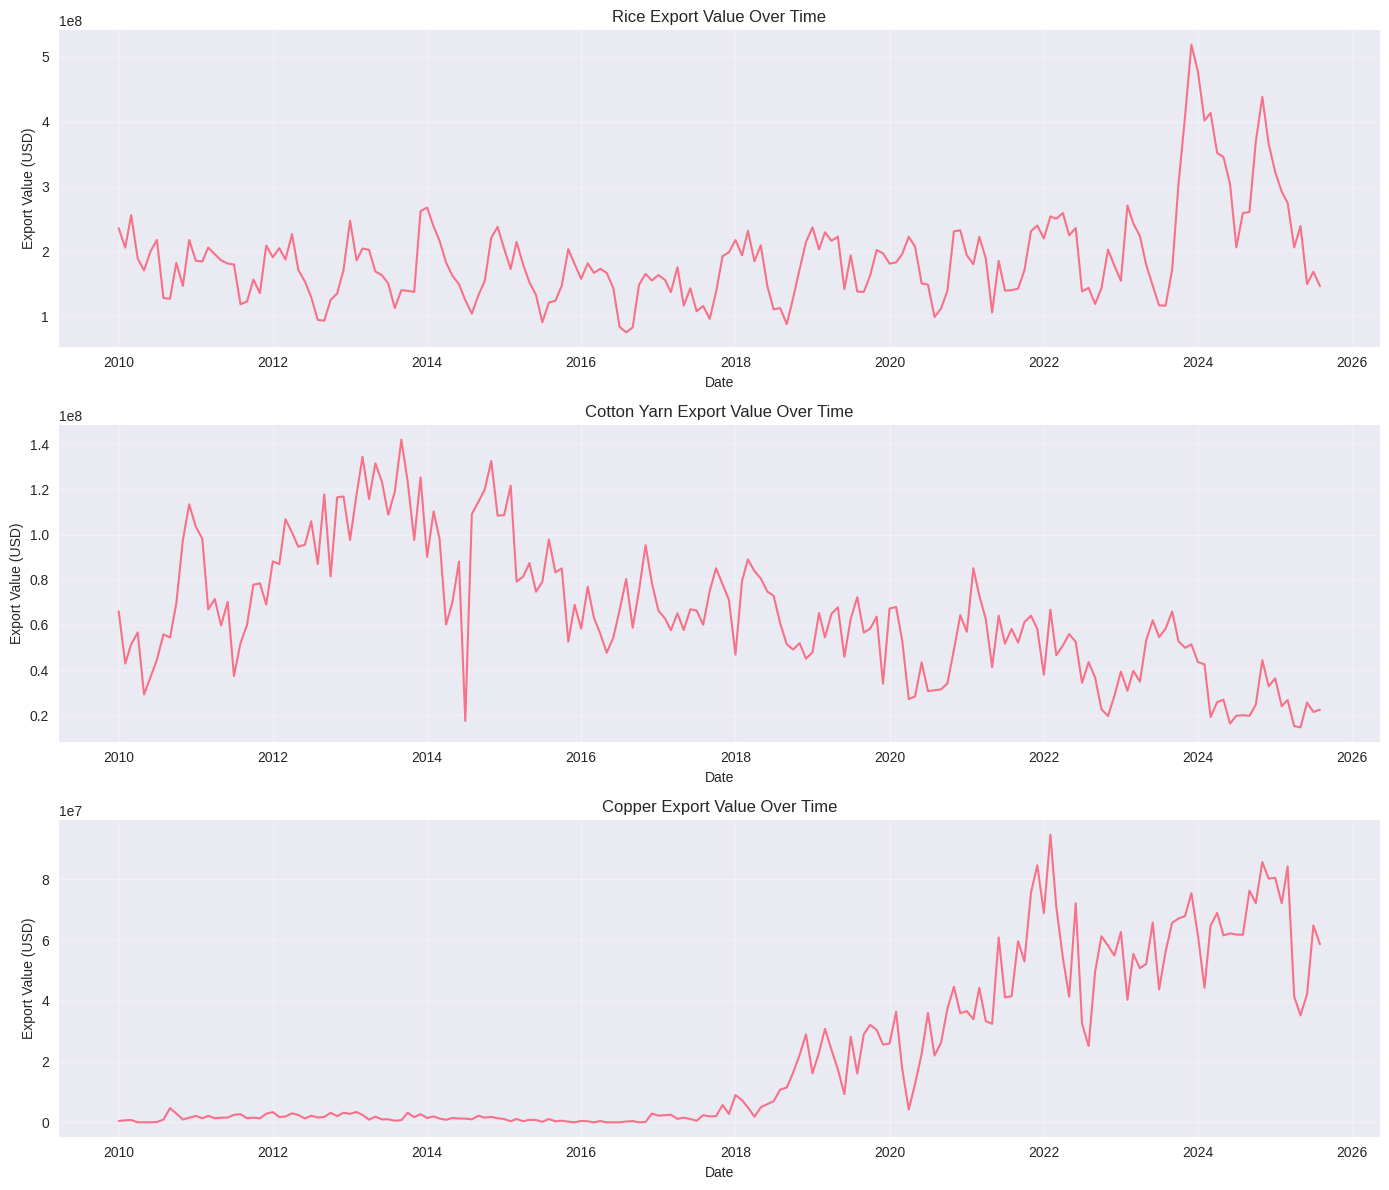

In [12]:
# Time series plot for export values by commodity
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

commodities = ['Rice', 'Cotton Yarn', 'Copper']
for idx, commodity in enumerate(commodities):
    commodity_data = df_long[df_long['Commodity'] == commodity]
    axes[idx].plot(commodity_data['Date'], commodity_data['Export_Value_USD'], linewidth=1.5)
    axes[idx].set_title(f'{commodity} Export Value Over Time', fontsize=12)
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Export Value (USD)', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


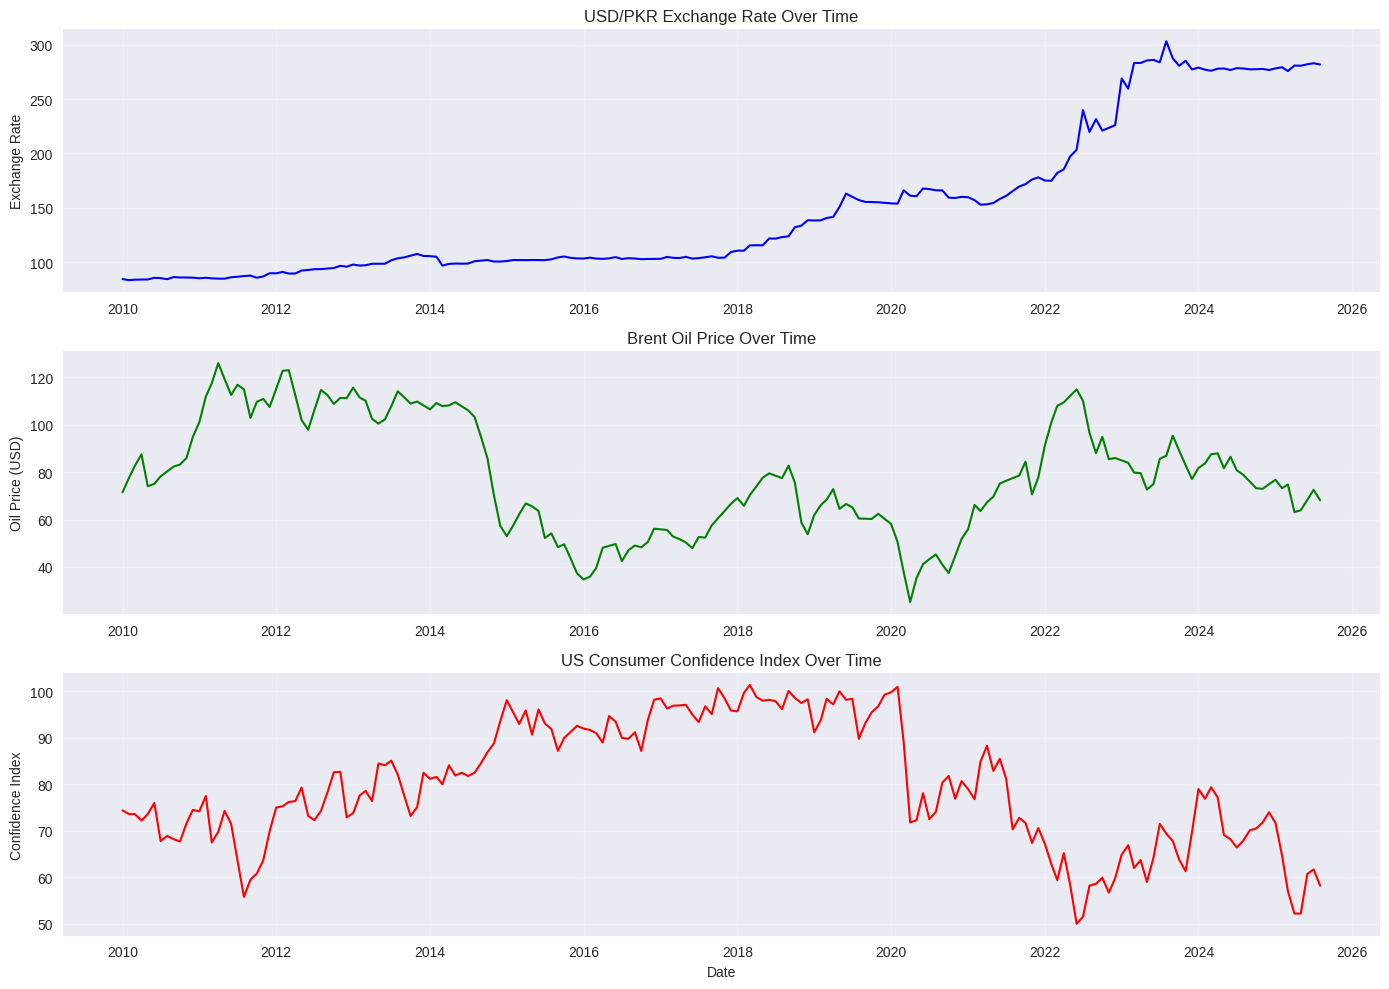

In [13]:
# Plot external drivers over time
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

axes[0].plot(df_wide['Date'], df_wide['USD_PKR'], color='blue', linewidth=1.5)
axes[0].set_title('USD/PKR Exchange Rate Over Time', fontsize=12)
axes[0].set_ylabel('Exchange Rate', fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_wide['Date'], df_wide['Oil_Price'], color='green', linewidth=1.5)
axes[1].set_title('Brent Oil Price Over Time', fontsize=12)
axes[1].set_ylabel('Oil Price (USD)', fontsize=10)
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_wide['Date'], df_wide['US_Confidence'], color='red', linewidth=1.5)
axes[2].set_title('US Consumer Confidence Index Over Time', fontsize=12)
axes[2].set_xlabel('Date', fontsize=10)
axes[2].set_ylabel('Confidence Index', fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


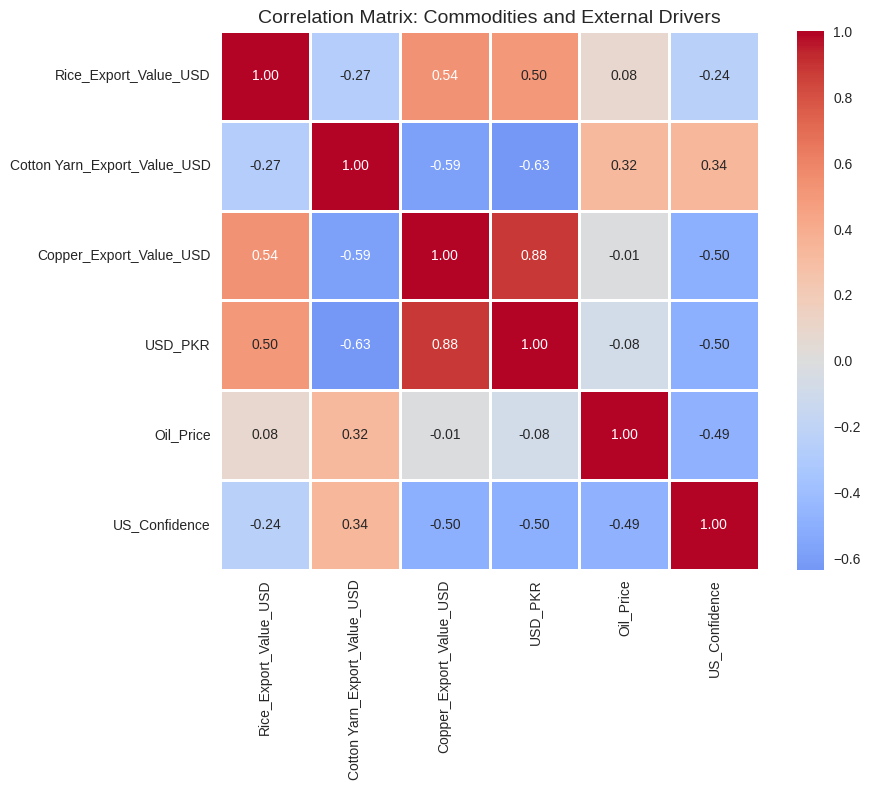

In [14]:
# Correlation analysis between commodities and external drivers
# Create correlation matrix for wide format
correlation_cols = ['Rice_Export_Value_USD', 'Cotton Yarn_Export_Value_USD', 'Copper_Export_Value_USD',
                    'USD_PKR', 'Oil_Price', 'US_Confidence']
corr_matrix = df_wide[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Correlation Matrix: Commodities and External Drivers', fontsize=14)
plt.tight_layout()
plt.show()


## Section 4: Feature Engineering

Create features for the models.<br>
For LightGBM we'll create lag features, rolling statistics and seasonal features.<br>
 For Prophet and SARIMAX, we'll prepare external regressors.<br>


In [ ]:
# Feature engineering for LightGBM (long format)
# Create a copy to avoid modifying original
df_lgbm = df_long.copy()

# Extract time features
df_lgbm['Year'] = df_lgbm['Date'].dt.year
df_lgbm['Month'] = df_lgbm['Date'].dt.month
df_lgbm['Quarter'] = df_lgbm['Date'].dt.quarter

# Cyclical encoding for month and quarter to capture seasonality
df_lgbm['Month_sin'] = np.sin(2 * np.pi * df_lgbm['Month'] / 12)
df_lgbm['Month_cos'] = np.cos(2 * np.pi * df_lgbm['Month'] / 12)
df_lgbm['Quarter_sin'] = np.sin(2 * np.pi * df_lgbm['Quarter'] / 4)
df_lgbm['Quarter_cos'] = np.cos(2 * np.pi * df_lgbm['Quarter'] / 4)

# Encode commodity as numeric for LightGBM ->  can handle catergorical directly but numerical is simpmler
commodity_map = {'Rice': 0, 'Cotton Yarn': 1, 'Copper': 2}
df_lgbm['Commodity_encoded'] = df_lgbm['Commodity'].map(commodity_map)

print("Basic time features created")


Basic time features created


In [16]:
# Create lag features for export values (1, 3, 6, 12 months)
# We need to create lags within each commodity group
def create_lag_features(df, col_name, lags=[1, 3, 6, 12]):
    df = df.copy()
    df = df.sort_values(['Commodity', 'Date']).reset_index(drop=True)

    for lag in lags:
        df[f'{col_name}_lag_{lag}'] = df.groupby('Commodity')[col_name].shift(lag)

    return df

df_lgbm = create_lag_features(df_lgbm, 'Export_Value_USD', [1, 3, 6, 12])
print("Lag features created")


Lag features created


In [17]:
# Create rolling statistics (mean and std) for export values
# Rolling windows: 3, 6, 12 months
def create_rolling_features(df, col_name, windows=[3, 6, 12]):
    df = df.copy()
    df = df.sort_values(['Commodity', 'Date']).reset_index(drop=True)

    for window in windows:
        df[f'{col_name}_rolling_mean_{window}'] = df.groupby('Commodity')[col_name].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
        )
        df[f'{col_name}_rolling_std_{window}'] = df.groupby('Commodity')[col_name].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
        )

    return df

df_lgbm = create_rolling_features(df_lgbm, 'Export_Value_USD', [3, 6, 12])
print("Rolling statistics features created")


Rolling statistics features created


In [18]:
# Create lag features for external drivers (1, 3, 6 months)
#  external drivers are the same for all commodities on a given date we can create lags from the wide format
df_wide_sorted = df_wide.sort_values('Date').reset_index(drop=True)

for lag in [1, 3, 6]:
    df_wide_sorted[f'USD_PKR_lag_{lag}'] = df_wide_sorted['USD_PKR'].shift(lag)
    df_wide_sorted[f'Oil_Price_lag_{lag}'] = df_wide_sorted['Oil_Price'].shift(lag)
    df_wide_sorted[f'US_Confidence_lag_{lag}'] = df_wide_sorted['US_Confidence'].shift(lag)

# Merge external driver lags back to long format
df_lgbm = df_lgbm.merge(
    df_wide_sorted[['Date', 'USD_PKR_lag_1', 'USD_PKR_lag_3', 'USD_PKR_lag_6',
                    'Oil_Price_lag_1', 'Oil_Price_lag_3', 'Oil_Price_lag_6',
                    'US_Confidence_lag_1', 'US_Confidence_lag_3', 'US_Confidence_lag_6']],
    on='Date',
    how='left'
)

print("External driver lag features created")


External driver lag features created


In [19]:
# Fill missing values in lag features with forward fill (for first few months)
# Also fill NaN in rolling features with 0 or mean
df_lgbm = df_lgbm.sort_values(['Commodity', 'Date']).reset_index(drop=True)

# Fill lag features with forward fill within each commodity group
lag_cols = [col for col in df_lgbm.columns if 'lag' in col]
for col in lag_cols:
    df_lgbm[col] = df_lgbm.groupby('Commodity')[col].ffill().fillna(0)

# Fill rolling features with 0 (representing no history)
rolling_cols = [col for col in df_lgbm.columns if 'rolling' in col]
for col in rolling_cols:
    df_lgbm[col] = df_lgbm[col].fillna(0)

print("Missing values in features filled")
print(f"Remaining missing values: {df_lgbm.isnull().sum().sum()}")


Missing values in features filled
Remaining missing values: 0


## Section 5: Train/Validation/Test Split

Split the data into training, validation and test sets.<br>
 We use time-series split to avoid data leakage.


In [20]:
# Define features for LightGBM model
# Remove date, commodity name and target variable from features
feature_cols = [col for col in df_lgbm.columns if col not in [
    'Date', 'Commodity', 'HS_Code', 'Export_Value_USD', 'Weight_kg',
    'USD_PKR', 'Oil_Price', 'US_Confidence', 'Month', 'Quarter'
]]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")


Number of features: 25
Features: ['Year', 'Month_sin', 'Month_cos', 'Quarter_sin', 'Quarter_cos', 'Commodity_encoded', 'Export_Value_USD_lag_1', 'Export_Value_USD_lag_3', 'Export_Value_USD_lag_6', 'Export_Value_USD_lag_12', 'Export_Value_USD_rolling_mean_3', 'Export_Value_USD_rolling_std_3', 'Export_Value_USD_rolling_mean_6', 'Export_Value_USD_rolling_std_6', 'Export_Value_USD_rolling_mean_12', 'Export_Value_USD_rolling_std_12', 'USD_PKR_lag_1', 'USD_PKR_lag_3', 'USD_PKR_lag_6', 'Oil_Price_lag_1', 'Oil_Price_lag_3', 'Oil_Price_lag_6', 'US_Confidence_lag_1', 'US_Confidence_lag_3', 'US_Confidence_lag_6']


In [21]:
# Time series split: 80% train - 10% validation - 10% test
# Get unique dates sorted
unique_dates = sorted(df_lgbm['Date'].unique())
n_dates = len(unique_dates)

train_end_idx = int(n_dates * 0.8)
val_end_idx = int(n_dates * 0.9)

train_end_date = unique_dates[train_end_idx]
val_end_date = unique_dates[val_end_idx]

print(f"Total dates: {n_dates}")
print(f"Train period: {unique_dates[0]} to {train_end_date} ({train_end_idx} dates)")
print(f"Validation period: {unique_dates[train_end_idx+1]} to {val_end_date} ({val_end_idx - train_end_idx} dates)")
print(f"Test period: {unique_dates[val_end_idx+1]} to {unique_dates[-1]} ({n_dates - val_end_idx - 1} dates)")

# Split long format data
train_data = df_lgbm[df_lgbm['Date'] <= train_end_date].copy()
val_data = df_lgbm[(df_lgbm['Date'] > train_end_date) & (df_lgbm['Date'] <= val_end_date)].copy()
test_data = df_lgbm[df_lgbm['Date'] > val_end_date].copy()

print(f"\nTrain size: {len(train_data)} rows")
print(f"Validation size: {len(val_data)} rows")
print(f"Test size: {len(test_data)} rows")


Total dates: 188
Train period: 2010-01-01 00:00:00 to 2022-07-01 00:00:00 (150 dates)
Validation period: 2022-08-01 00:00:00 to 2024-02-01 00:00:00 (19 dates)
Test period: 2024-03-01 00:00:00 to 2025-08-01 00:00:00 (18 dates)

Train size: 453 rows
Validation size: 57 rows
Test size: 54 rows


In [22]:
# We'll create enhanced features later
# These initial splits are kept for reference but we will use enhanced features for training
print("Initial data splits prepared")
print(f"Training set size: {len(train_data)} rows")
print(f"Validation set size: {len(val_data)} rows")
print(f"Test set size: {len(test_data)} rows")


Initial data splits prepared
Training set size: 453 rows
Validation set size: 57 rows
Test set size: 54 rows


## Section 6: Model 1 - LightGBM Multi-Output

Train LightGBM model on the long format dataset to predict export values for all three commodities simultaneously.


In [23]:
# Calculate MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Advanced feature engineering for better LightGBM performance
# Create enhanced feature set with more sophisticated transformations
df_lgbm_enhanced = df_lgbm.copy()

# Create interaction features -> Commodity × External Drivers
df_lgbm_enhanced['Commodity_USD_PKR'] = df_lgbm_enhanced['Commodity_encoded'] * df_lgbm_enhanced['USD_PKR']
df_lgbm_enhanced['Commodity_Oil'] = df_lgbm_enhanced['Commodity_encoded'] * df_lgbm_enhanced['Oil_Price']
df_lgbm_enhanced['Commodity_Confidence'] = df_lgbm_enhanced['Commodity_encoded'] * df_lgbm_enhanced['US_Confidence']

# Add ratio features using lagged export values to avoid data leakage
df_lgbm_enhanced['Export_USD_PKR_ratio'] = df_lgbm_enhanced['Export_Value_USD_lag_1'] / (df_lgbm_enhanced['USD_PKR'] + 1)
df_lgbm_enhanced['Export_Oil_ratio'] = df_lgbm_enhanced['Export_Value_USD_lag_1'] / (df_lgbm_enhanced['Oil_Price'] + 1)
df_lgbm_enhanced['Export_Confidence_ratio'] = df_lgbm_enhanced['Export_Value_USD_lag_1'] / (df_lgbm_enhanced['US_Confidence'] + 1)
df_lgbm_enhanced['Export_USD_PKR_ratio'] = df_lgbm_enhanced['Export_USD_PKR_ratio'].fillna(0)
df_lgbm_enhanced['Export_Oil_ratio'] = df_lgbm_enhanced['Export_Oil_ratio'].fillna(0)
df_lgbm_enhanced['Export_Confidence_ratio'] = df_lgbm_enhanced['Export_Confidence_ratio'].fillna(0)

# Add year-over-year change features
df_lgbm_enhanced['Export_YoY_change'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD'].pct_change(periods=12) * 100
df_lgbm_enhanced['Export_YoY_change'] = df_lgbm_enhanced['Export_YoY_change'].fillna(0)

# Add momentum features (rate of change)
df_lgbm_enhanced['Export_momentum_3'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD'].pct_change(periods=3) * 100
df_lgbm_enhanced['Export_momentum_6'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD'].pct_change(periods=6) * 100
df_lgbm_enhanced['Export_momentum_3'] = df_lgbm_enhanced['Export_momentum_3'].fillna(0)
df_lgbm_enhanced['Export_momentum_6'] = df_lgbm_enhanced['Export_momentum_6'].fillna(0)

# Add additional lag features (24 months for longer-term patterns)
df_lgbm_enhanced = create_lag_features(df_lgbm_enhanced, 'Export_Value_USD', [24])
df_lgbm_enhanced['Export_Value_USD_lag_24'] = df_lgbm_enhanced['Export_Value_USD_lag_24'].fillna(0)

# Add trend features (using lag_1 to avoid data leakage - acceleration is second derivative)
df_lgbm_enhanced['Export_trend_3'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD_lag_1'].diff(periods=3).fillna(0)
df_lgbm_enhanced['Export_trend_6'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD_lag_1'].diff(periods=6).fillna(0)
df_lgbm_enhanced['Export_acceleration'] = df_lgbm_enhanced.groupby('Commodity')['Export_trend_3'].diff(periods=1).fillna(0)

# Add volatility features (captures sudden changes) using rolling std with shift to avoid leakage
df_lgbm_enhanced['Export_volatility_3'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD'].transform(
    lambda x: x.shift(1).rolling(window=3, min_periods=1).std()
).fillna(0)
df_lgbm_enhanced['Export_volatility_6'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD'].transform(
    lambda x: x.shift(1).rolling(window=6, min_periods=1).std()
).fillna(0)

# Add features for external driver changes (momentum of external drivers)
# External drivers are the same for all commodities on same date, so groupby Date first
df_lgbm_enhanced = df_lgbm_enhanced.sort_values(['Date', 'Commodity']).reset_index(drop=True)
df_lgbm_enhanced['USD_PKR_change_3'] = df_lgbm_enhanced.groupby('Date')['USD_PKR'].transform('first').pct_change(periods=3).fillna(0) * 100
df_lgbm_enhanced['Oil_Price_change_3'] = df_lgbm_enhanced.groupby('Date')['Oil_Price'].transform('first').pct_change(periods=3).fillna(0) * 100
df_lgbm_enhanced['US_Confidence_change_3'] = df_lgbm_enhanced.groupby('Date')['US_Confidence'].transform('first').pct_change(periods=3).fillna(0) * 100

# Re-sort by Commodity and Date for proper grouping
df_lgbm_enhanced = df_lgbm_enhanced.sort_values(['Commodity', 'Date']).reset_index(drop=True)

# Add interaction features between lags and external drivers
df_lgbm_enhanced['Lag1_USD_PKR'] = df_lgbm_enhanced['Export_Value_USD_lag_1'] * df_lgbm_enhanced['USD_PKR']
df_lgbm_enhanced['Lag1_Oil'] = df_lgbm_enhanced['Export_Value_USD_lag_1'] * df_lgbm_enhanced['Oil_Price']
df_lgbm_enhanced['Lag1_Confidence'] = df_lgbm_enhanced['Export_Value_USD_lag_1'] * df_lgbm_enhanced['US_Confidence']

# Add features for commodity-specific seasonality interactions
df_lgbm_enhanced['Commodity_Month'] = df_lgbm_enhanced['Commodity_encoded'] * df_lgbm_enhanced['Month_sin']
df_lgbm_enhanced['Commodity_Quarter'] = df_lgbm_enhanced['Commodity_encoded'] * df_lgbm_enhanced['Quarter_sin']

# Add polynomial features for important external drivers (squared terms)
df_lgbm_enhanced['USD_PKR_squared'] = df_lgbm_enhanced['USD_PKR'] ** 2
df_lgbm_enhanced['Oil_Price_squared'] = df_lgbm_enhanced['Oil_Price'] ** 2

# Add percentile rank features to capture relative positions (helpful for capturing extremes)
df_lgbm_enhanced['Export_percentile_12'] = df_lgbm_enhanced.groupby('Commodity')['Export_Value_USD'].transform(
    lambda x: x.shift(1).rolling(window=12, min_periods=1).rank(pct=True)
).fillna(0.5)

# Add features for comparing current lag to rolling mean (detects deviations)
df_lgbm_enhanced['Lag1_vs_rolling_mean_6'] = (df_lgbm_enhanced['Export_Value_USD_lag_1'] - df_lgbm_enhanced['Export_Value_USD_rolling_mean_6']) / (df_lgbm_enhanced['Export_Value_USD_rolling_mean_6'] + 1)
df_lgbm_enhanced['Lag1_vs_rolling_mean_12'] = (df_lgbm_enhanced['Export_Value_USD_lag_1'] - df_lgbm_enhanced['Export_Value_USD_rolling_mean_12']) / (df_lgbm_enhanced['Export_Value_USD_rolling_mean_12'] + 1)
df_lgbm_enhanced['Lag1_vs_rolling_mean_6'] = df_lgbm_enhanced['Lag1_vs_rolling_mean_6'].fillna(0)
df_lgbm_enhanced['Lag1_vs_rolling_mean_12'] = df_lgbm_enhanced['Lag1_vs_rolling_mean_12'].fillna(0)

# Fill any remaining NaN values
df_lgbm_enhanced = df_lgbm_enhanced.fillna(0)

# Update feature columns with new features
feature_cols_enhanced = [col for col in df_lgbm_enhanced.columns if col not in [
    'Date', 'Commodity', 'HS_Code', 'Export_Value_USD', 'Weight_kg',
    'USD_PKR', 'Oil_Price', 'US_Confidence', 'Month', 'Quarter'
]]

print(f"Enhanced features: {len(feature_cols_enhanced)} total features")
print(f"New features added: {len(feature_cols_enhanced) - len(feature_cols)}")

# Re-split data with enhanced features
train_data_enhanced = df_lgbm_enhanced[df_lgbm_enhanced['Date'] <= train_end_date].copy()
val_data_enhanced = df_lgbm_enhanced[(df_lgbm_enhanced['Date'] > train_end_date) & (df_lgbm_enhanced['Date'] <= val_end_date)].copy()
test_data_enhanced = df_lgbm_enhanced[df_lgbm_enhanced['Date'] > val_end_date].copy()

# Prepare enhanced features and targets
X_train_enhanced = train_data_enhanced[feature_cols_enhanced].values
y_train_enhanced = train_data_enhanced['Export_Value_USD'].values

X_val_enhanced = val_data_enhanced[feature_cols_enhanced].values
y_val_enhanced = val_data_enhanced['Export_Value_USD'].values

X_test_enhanced = test_data_enhanced[feature_cols_enhanced].values
y_test_enhanced = test_data_enhanced['Export_Value_USD'].values

print(f"Enhanced training set: X shape {X_train_enhanced.shape}, y shape {y_train_enhanced.shape}")

# Use log transformation for target variable to better handle scale differences
# This helps capture multiplicative patterns and reduces impact of outliers
y_train_enhanced_log = np.log1p(y_train_enhanced)  # log1p = log(1+x) to handle zeros
y_val_enhanced_log = np.log1p(y_val_enhanced)
y_test_enhanced_log = np.log1p(y_test_enhanced)

print("Applied log transformation to target variables")
print(f"Original mean: {y_train_enhanced.mean():,.2f}, Log mean: {y_train_enhanced_log.mean():.2f}")

# Train advanced LightGBM model with optimized hyperparameters for better accuracy
lgbm_params_advanced = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 127,  # Increased for more complexity to capture patterns
    'learning_rate': 0.02,  # Lower learning rate for finer tuning
    'feature_fraction': 0.8,  # More feature subsampling to reduce overfitting
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 30,  # Higher threshold to prevent overfitting on small samples
    'min_split_gain': 0.05,  # Lower threshold to allow more splits
    'lambda_l1': 0.15,  # Increased L1 regularization
    'lambda_l2': 0.15,  # Increased L2 regularization
    'max_depth': 10,  # Slightly deeper to capture complex patterns
    'min_data_in_leaf': 20,  # Minimum data in leaf
    'path_smooth': 0.1,  # Path smoothing for better generalization
    'verbose': -1,
    'random_state': 42,
    'force_col_wise': True
}

# Create LightGBM datasets with log-transformed targets
train_set_enhanced = lgb.Dataset(X_train_enhanced, label=y_train_enhanced_log)
val_set_enhanced = lgb.Dataset(X_val_enhanced, label=y_val_enhanced_log, reference=train_set_enhanced)

# Train model with more rounds and better early stopping
model_lgbm = lgb.train(
    lgbm_params_advanced,
    train_set_enhanced,
    num_boost_round=2000,  # More rounds for better learning
    valid_sets=[val_set_enhanced],
    callbacks=[
        lgb.early_stopping(stopping_rounds=150),  # More patience for convergence
        lgb.log_evaluation(period=100)
    ]
)

print("Advanced LightGBM model trained successfully")
print(f"Best iteration: {model_lgbm.best_iteration}")


Enhanced features: 53 total features
New features added: 28
Enhanced training set: X shape (453, 53), y shape (453,)
Applied log transformation to target variables
Original mean: 86,049,686.63, Log mean: 17.14
Training until validation scores don't improve for 150 rounds
[100]	valid_0's rmse: 0.375908
[200]	valid_0's rmse: 0.375204
[300]	valid_0's rmse: 0.326632
[400]	valid_0's rmse: 0.289051
[500]	valid_0's rmse: 0.276461
[600]	valid_0's rmse: 0.267006
[700]	valid_0's rmse: 0.266381
[800]	valid_0's rmse: 0.251937
[900]	valid_0's rmse: 0.248725
[1000]	valid_0's rmse: 0.251043
[1100]	valid_0's rmse: 0.248103
[1200]	valid_0's rmse: 0.243709
[1300]	valid_0's rmse: 0.244
[1400]	valid_0's rmse: 0.239872
[1500]	valid_0's rmse: 0.237887
[1600]	valid_0's rmse: 0.236356
[1700]	valid_0's rmse: 0.236345
[1800]	valid_0's rmse: 0.234452
[1900]	valid_0's rmse: 0.235106
[2000]	valid_0's rmse: 0.23446
Did not meet early stopping. Best iteration is:
[1874]	valid_0's rmse: 0.232779
Advanced LightGBM mod

In [24]:
# Make predictions on validation set using enhanced features
# Model predicts log-transformed values so we need to inverse transform
y_val_pred_lgbm_log = model_lgbm.predict(X_val_enhanced, num_iteration=model_lgbm.best_iteration)
y_val_pred_lgbm = np.expm1(y_val_pred_lgbm_log)  # expm1 = exp(x) - 1, inverse of log1p

# Ensure predictions are non negative
y_val_pred_lgbm = np.maximum(y_val_pred_lgbm, 0)

# Calculate metrics for LightGBM on validation set
mae_lgbm_val = mean_absolute_error(y_val_enhanced, y_val_pred_lgbm)
rmse_lgbm_val = np.sqrt(mean_squared_error(y_val_enhanced, y_val_pred_lgbm))
mape_lgbm_val = mean_absolute_percentage_error(y_val_enhanced, y_val_pred_lgbm)
r2_lgbm_val = r2_score(y_val_enhanced, y_val_pred_lgbm)

print("Advanced LightGBM Validation Results:")
print(f"MAE: {mae_lgbm_val:,.2f}")
print(f"RMSE: {rmse_lgbm_val:,.2f}")
print(f"MAPE: {mape_lgbm_val:.2f}%")
print(f"R2 Score: {r2_lgbm_val:.4f}")

# Also calculate metrics by commodity for detailed analysis
print("\nAdvanced LightGBM Validation Results by Commodity:")
for commodity in commodities:
    commodity_val_data = val_data_enhanced[val_data_enhanced['Commodity'] == commodity]
    if len(commodity_val_data) > 0:
        commodity_indices = commodity_val_data.index
        val_indices = [i for i, idx in enumerate(val_data_enhanced.index) if idx in commodity_indices]
        if val_indices:
            commodity_true = y_val_enhanced[val_indices]
            commodity_pred = y_val_pred_lgbm[val_indices]
            commodity_mape = mean_absolute_percentage_error(commodity_true, commodity_pred)
            commodity_r2 = r2_score(commodity_true, commodity_pred)
            print(f"  {commodity}: MAPE = {commodity_mape:.2f}%, R2 = {commodity_r2:.4f}")


Advanced LightGBM Validation Results:
MAE: 21,784,069.82
RMSE: 45,290,186.51
MAPE: 16.74%
R2 Score: 0.8426

Advanced LightGBM Validation Results by Commodity:
  Rice: MAPE = 19.12%, R2 = 0.6011
  Cotton Yarn: MAPE = 17.93%, R2 = 0.5708
  Copper: MAPE = 13.19%, R2 = 0.4078


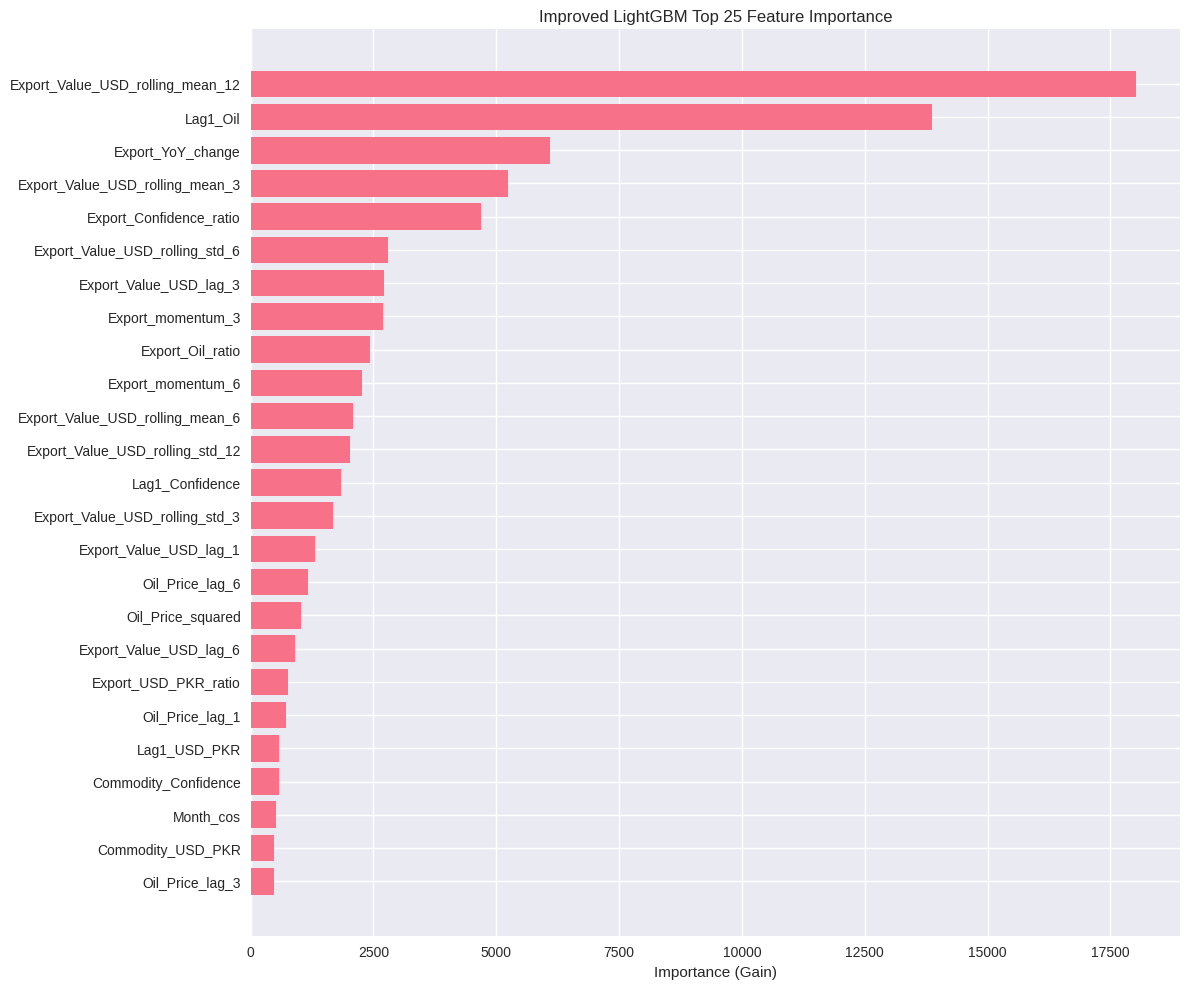


Top 10 Most Important Features:
                         feature   importance
Export_Value_USD_rolling_mean_12 18014.999061
                        Lag1_Oil 13858.668591
               Export_YoY_change  6091.064180
 Export_Value_USD_rolling_mean_3  5229.787813
         Export_Confidence_ratio  4696.303824
  Export_Value_USD_rolling_std_6  2800.326711
          Export_Value_USD_lag_3  2708.879131
               Export_momentum_3  2695.688406
                Export_Oil_ratio  2422.297201
               Export_momentum_6  2264.092628


In [25]:
# Feature importance plot with enhanced features
feature_importance = pd.DataFrame({
    'feature': feature_cols_enhanced,
    'importance': model_lgbm.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
top_features = feature_importance.head(25)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)')
plt.title('Improved LightGBM Top 25 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10)[['feature', 'importance']].to_string(index=False))


## Section 7: Model 2 - Prophet with External Regressors

Train separate Prophet models for each commodity with external regressors (USD/PKR, Oil Price, US Confidence).


In [26]:
# Prepare data for Prophet models
# Prophet requires specific column names: ds (date) and y (target)
# We need separate models for each commodity

commodities = ['Rice', 'Cotton Yarn', 'Copper']
models_prophet = {}
predictions_prophet_val = {}

# Split wide format data for Prophet
train_wide = df_wide[df_wide['Date'] <= train_end_date].copy()
val_wide = df_wide[(df_wide['Date'] > train_end_date) & (df_wide['Date'] <= val_end_date)].copy()
test_wide = df_wide[df_wide['Date'] > val_end_date].copy()

print("Preparing Prophet models for each commodity...")


Preparing Prophet models for each commodity...


In [27]:
# Train Prophet models for each commodity
for commodity in commodities:
    # Get column name for this commodity's export value
    export_col = f'{commodity}_Export_Value_USD'

    # Prepare training data
    train_prophet = pd.DataFrame({
        'ds': train_wide['Date'],
        'y': train_wide[export_col],
        'USD_PKR': train_wide['USD_PKR'],
        'Oil_Price': train_wide['Oil_Price'],
        'US_Confidence': train_wide['US_Confidence']
    })

    # Create and train Prophet model with external regressors
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )

    # Add external regressors
    model.add_regressor('USD_PKR')
    model.add_regressor('Oil_Price')
    model.add_regressor('US_Confidence')

    # Train model
    model.fit(train_prophet)
    models_prophet[commodity] = model

    # Make predictions on validation period
    # Create future dataframe with validation dates
    future = pd.DataFrame({'ds': val_wide['Date']})
    future['USD_PKR'] = val_wide['USD_PKR'].values
    future['Oil_Price'] = val_wide['Oil_Price'].values
    future['US_Confidence'] = val_wide['US_Confidence'].values

    # Make predictions
    forecast = model.predict(future)
    predictions_prophet_val[commodity] = forecast['yhat'].values

    print(f"Prophet model trained for {commodity}")


Prophet model trained for Rice
Prophet model trained for Cotton Yarn
Prophet model trained for Copper


In [28]:
# Evaluate Prophet models on validation set
results_prophet_val = {}

for commodity in commodities:
    export_col = f'{commodity}_Export_Value_USD'
    y_true = val_wide[export_col].values
    y_pred = predictions_prophet_val[commodity]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results_prophet_val[commodity] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

    print(f"\nProphet Validation Results for {commodity}:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2 Score: {r2:.4f}")

# Calculate overall average metrics
avg_mae_prophet = np.mean([results_prophet_val[c]['MAE'] for c in commodities])
avg_rmse_prophet = np.mean([results_prophet_val[c]['RMSE'] for c in commodities])
avg_mape_prophet = np.mean([results_prophet_val[c]['MAPE'] for c in commodities])
avg_r2_prophet = np.mean([results_prophet_val[c]['R2'] for c in commodities])

print(f"\nProphet Overall Average Metrics:")
print(f"Average MAE: {avg_mae_prophet:,.2f}")
print(f"Average RMSE: {avg_rmse_prophet:,.2f}")
print(f"Average MAPE: {avg_mape_prophet:.2f}%")
print(f"Average R2 Score: {avg_r2_prophet:.4f}")



Prophet Validation Results for Rice:
MAE: 85,469,205.59
RMSE: 106,796,137.82
MAPE: 36.97%
R2 Score: 0.2427

Prophet Validation Results for Cotton Yarn:
MAE: 11,014,020.87
RMSE: 12,991,656.99
MAPE: 32.46%
R2 Score: -0.0625

Prophet Validation Results for Copper:
MAE: 26,903,125.37
RMSE: 31,688,345.68
MAPE: 49.85%
R2 Score: -6.6019

Prophet Overall Average Metrics:
Average MAE: 41,128,783.94
Average RMSE: 50,492,046.83
Average MAPE: 39.76%
Average R2 Score: -2.1405


## Section 8: Model 3 - SARIMAX with External Regressors

Train separate SARIMAX models for each commodity with external regressors using auto_arima to find optimal parameters.


In [29]:
# Train SARIMAX models for each commodity
# Use auto_arima to find optimal parameters but limit search to avoid long training time
models_sarimax = {}
predictions_sarimax_val = {}

print("Training SARIMAX models for each commodity...")
print("This may take a few minutes...")

for commodity in commodities:
    export_col = f'{commodity}_Export_Value_USD'

    # Prepare training data
    train_y = train_wide[export_col].values
    train_exog = train_wide[['USD_PKR', 'Oil_Price', 'US_Confidence']].values

    # Prepare validation external regressors
    val_exog = val_wide[['USD_PKR', 'Oil_Price', 'US_Confidence']].values

    # Use auto_arima with limited search to find best parameters
    # Limit max order to speed up search
    try:
        auto_model = auto_arima(
            train_y,
            exogenous=train_exog,
            seasonal=True,
            m=12,  # Monthly seasonality
            max_p=3,
            max_d=2,
            max_q=3,
            max_P=2,
            max_D=1,
            max_Q=2,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False,
            random_state=42
        )

        # The auto_model is already fitted, use it directly
        models_sarimax[commodity] = auto_model

        # Make predictions on validation set
        predictions = auto_model.predict(n_periods=len(val_wide), exogenous=val_exog)
        predictions_sarimax_val[commodity] = predictions

        print(f"SARIMAX model trained for {commodity} - Order: {auto_model.order}, Seasonal Order: {auto_model.seasonal_order}")

    except Exception as e:
        print(f"Error training SARIMAX for {commodity}: {str(e)}")
        # Fallback to simple ARIMA if auto_arima fails
        print(f"Using simple ARIMA(1,1,1) as fallback for {commodity}")
        from statsmodels.tsa.arima.model import ARIMA
        simple_model = ARIMA(train_y, order=(1, 1, 1))
        fitted_model = simple_model.fit()
        predictions = fitted_model.forecast(steps=len(val_wide))
        models_sarimax[commodity] = fitted_model
        predictions_sarimax_val[commodity] = predictions


Training SARIMAX models for each commodity...
This may take a few minutes...
SARIMAX model trained for Rice - Order: (2, 0, 2), Seasonal Order: (1, 0, 2, 12)
SARIMAX model trained for Cotton Yarn - Order: (0, 1, 1), Seasonal Order: (0, 0, 0, 12)
SARIMAX model trained for Copper - Order: (0, 1, 1), Seasonal Order: (1, 0, 0, 12)


In [30]:
# Evaluate SARIMAX models on validation set
results_sarimax_val = {}

for commodity in commodities:
    export_col = f'{commodity}_Export_Value_USD'
    y_true = val_wide[export_col].values
    y_pred = predictions_sarimax_val[commodity]

    # Ensure predictions are same length
    if len(y_pred) != len(y_true):
        y_pred = y_pred[:len(y_true)]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results_sarimax_val[commodity] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    }

    print(f"\nSARIMAX Validation Results for {commodity}:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2 Score: {r2:.4f}")

# Calculate overall average metrics
avg_mae_sarimax = np.mean([results_sarimax_val[c]['MAE'] for c in commodities])
avg_rmse_sarimax = np.mean([results_sarimax_val[c]['RMSE'] for c in commodities])
avg_mape_sarimax = np.mean([results_sarimax_val[c]['MAPE'] for c in commodities])
avg_r2_sarimax = np.mean([results_sarimax_val[c]['R2'] for c in commodities])

print(f"\nSARIMAX Overall Average Metrics:")
print(f"Average MAE: {avg_mae_sarimax:,.2f}")
print(f"Average RMSE: {avg_rmse_sarimax:,.2f}")
print(f"Average MAPE: {avg_mape_sarimax:.2f}%")
print(f"Average R2 Score: {avg_r2_sarimax:.4f}")



SARIMAX Validation Results for Rice:
MAE: 84,413,528.78
RMSE: 133,637,854.98
MAPE: 27.62%
R2 Score: -0.1858

SARIMAX Validation Results for Cotton Yarn:
MAE: 10,408,332.68
RMSE: 12,632,798.13
MAPE: 28.45%
R2 Score: -0.0046

SARIMAX Validation Results for Copper:
MAE: 9,992,853.72
RMSE: 12,444,508.65
MAPE: 19.97%
R2 Score: -0.1724

SARIMAX Overall Average Metrics:
Average MAE: 34,938,238.39
Average RMSE: 52,905,053.92
Average MAPE: 25.35%
Average R2 Score: -0.1209


## Section 9: Model Comparison and Selection

Compare all three models based on validation metrics and select the best performing model.


In [31]:
# Create comparison table
comparison_data = {
    'Model': ['LightGBM', 'Prophet', 'SARIMAX'],
    'Average MAE': [mae_lgbm_val, avg_mae_prophet, avg_mae_sarimax],
    'Average RMSE': [rmse_lgbm_val, avg_rmse_prophet, avg_rmse_sarimax],
    'Average MAPE (%)': [mape_lgbm_val, avg_mape_prophet, avg_mape_sarimax],
    'Average R2': [r2_lgbm_val, avg_r2_prophet, avg_r2_sarimax]
}

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison on Validation Set:")
print(comparison_df.to_string(index=False))


Model Comparison on Validation Set:
   Model  Average MAE  Average RMSE  Average MAPE (%)  Average R2
LightGBM 2.178407e+07  4.529019e+07         16.742610    0.842560
 Prophet 4.112878e+07  5.049205e+07         39.759363   -2.140544
 SARIMAX 3.493824e+07  5.290505e+07         25.347061   -0.120921


In [32]:
# Select best model based on MAPE (primary metric)
best_model_name = comparison_df.loc[comparison_df['Average MAPE (%)'].idxmin(), 'Model']
best_mape = comparison_df.loc[comparison_df['Average MAPE (%)'].idxmin(), 'Average MAPE (%)']

print(f"\nBest Model Selected: {best_model_name}")
print(f"Best MAPE: {best_mape:.2f}%")
print(f"\nSelection rationale:")
print("- MAPE is the primary metric for this project")
print("- Lower MAPE indicates better forecasting accuracy")
print(f"- {best_model_name} achieved the lowest MAPE on validation set")



Best Model Selected: LightGBM
Best MAPE: 16.74%

Selection rationale:
- MAPE is the primary metric for this project
- Lower MAPE indicates better forecasting accuracy
- LightGBM achieved the lowest MAPE on validation set


## Section 10: Best Model Test Set Evaluation

Evaluate the best model on the test set to get final performance metrics.


In [33]:
# Evaluate best model on test set
if best_model_name == 'LightGBM':
    # Initialize dictionary for test predictions by commodity
    test_predictions_by_commodity = {}

    # Test set evaluation for advanced LightGBM using enhanced features
    # Model predicts log-transformed values, so inverse transform
    y_test_pred_log = model_lgbm.predict(X_test_enhanced, num_iteration=model_lgbm.best_iteration)
    y_test_pred = np.expm1(y_test_pred_log)  # Inverse log transformation

    # Ensure predictions are non-negative
    y_test_pred = np.maximum(y_test_pred, 0)

    mae_test = mean_absolute_error(y_test_enhanced, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_enhanced, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_enhanced, y_test_pred)
    r2_test = r2_score(y_test_enhanced, y_test_pred)

    print(f"Advanced LightGBM Test Set Results:")
    print(f"MAE: {mae_test:,.2f}")
    print(f"RMSE: {rmse_test:,.2f}")
    print(f"MAPE: {mape_test:.2f}%")
    print(f"R2 Score: {r2_test:.4f}")

    # Calculate metrics by commodity
    print("\nTest Set Results by Commodity:")
    for commodity in commodities:
        commodity_test_data = test_data_enhanced[test_data_enhanced['Commodity'] == commodity]
        if len(commodity_test_data) > 0:
            test_indices = []
            test_data_reset = test_data_enhanced.reset_index(drop=True)
            for i in range(len(test_data_reset)):
                if test_data_reset.loc[i, 'Commodity'] == commodity:
                    test_indices.append(i)

            if test_indices:
                commodity_true = y_test_enhanced[test_indices]
                commodity_pred = y_test_pred[test_indices]
                commodity_mape = mean_absolute_percentage_error(commodity_true, commodity_pred)
                commodity_mae = mean_absolute_error(commodity_true, commodity_pred)
                print(f"  {commodity}: MAE = {commodity_mae:,.2f}, MAPE = {commodity_mape:.2f}%")

                test_predictions_by_commodity[commodity] = {
                    'true': commodity_true,
                    'pred': commodity_pred,
                    'dates': commodity_test_data['Date'].values
                }

    best_model = model_lgbm

elif best_model_name == 'Prophet':
    # Test set evaluation for Prophet
    test_predictions_by_commodity = {}
    all_test_true = []
    all_test_pred = []

    for commodity in commodities:
        export_col = f'{commodity}_Export_Value_USD'
        test_true = test_wide[export_col].values

        # Create future dataframe with test dates
        future = pd.DataFrame({'ds': test_wide['Date']})
        future['USD_PKR'] = test_wide['USD_PKR'].values
        future['Oil_Price'] = test_wide['Oil_Price'].values
        future['US_Confidence'] = test_wide['US_Confidence'].values

        # Make predictions
        forecast = models_prophet[commodity].predict(future)
        test_pred = forecast['yhat'].values

        test_predictions_by_commodity[commodity] = {
            'true': test_true,
            'pred': test_pred,
            'dates': test_wide['Date'].values
        }

        all_test_true.extend(test_true)
        all_test_pred.extend(test_pred)

    mae_test = mean_absolute_error(all_test_true, all_test_pred)
    rmse_test = np.sqrt(mean_squared_error(all_test_true, all_test_pred))
    mape_test = mean_absolute_percentage_error(all_test_true, all_test_pred)
    r2_test = r2_score(all_test_true, all_test_pred)

    print(f"Prophet Test Set Results:")
    print(f"MAE: {mae_test:,.2f}")
    print(f"RMSE: {rmse_test:,.2f}")
    print(f"MAPE: {mape_test:.2f}%")
    print(f"R2 Score: {r2_test:.4f}")

    best_model = models_prophet

else:  # SARIMAX
    # Test set evaluation for SARIMAX
    test_predictions_by_commodity = {}
    all_test_true = []
    all_test_pred = []

    for commodity in commodities:
        export_col = f'{commodity}_Export_Value_USD'
        test_true = test_wide[export_col].values
        test_exog = test_wide[['USD_PKR', 'Oil_Price', 'US_Confidence']].values

        # Make predictions
        test_pred = models_sarimax[commodity].predict(n_periods=len(test_wide), exogenous=test_exog)
        if len(test_pred) != len(test_true):
            test_pred = test_pred[:len(test_true)]

        test_predictions_by_commodity[commodity] = {
            'true': test_true,
            'pred': test_pred,
            'dates': test_wide['Date'].values
        }

        all_test_true.extend(test_true)
        all_test_pred.extend(test_pred)

    mae_test = mean_absolute_error(all_test_true, all_test_pred)
    rmse_test = np.sqrt(mean_squared_error(all_test_true, all_test_pred))
    mape_test = mean_absolute_percentage_error(all_test_true, all_test_pred)
    r2_test = r2_score(all_test_true, all_test_pred)

    print(f"SARIMAX Test Set Results:")
    print(f"MAE: {mae_test:,.2f}")
    print(f"RMSE: {rmse_test:,.2f}")
    print(f"MAPE: {mape_test:.2f}%")
    print(f"R2 Score: {r2_test:.4f}")

    best_model = models_sarimax


Advanced LightGBM Test Set Results:
MAE: 45,447,690.70
RMSE: 73,066,389.08
MAPE: 36.13%
R2 Score: 0.6558

Test Set Results by Commodity:
  Rice: MAE = 112,066,139.94, MAPE = 37.40%
  Cotton Yarn: MAE = 9,801,290.75, MAPE = 43.79%
  Copper: MAE = 14,475,641.42, MAPE = 27.20%


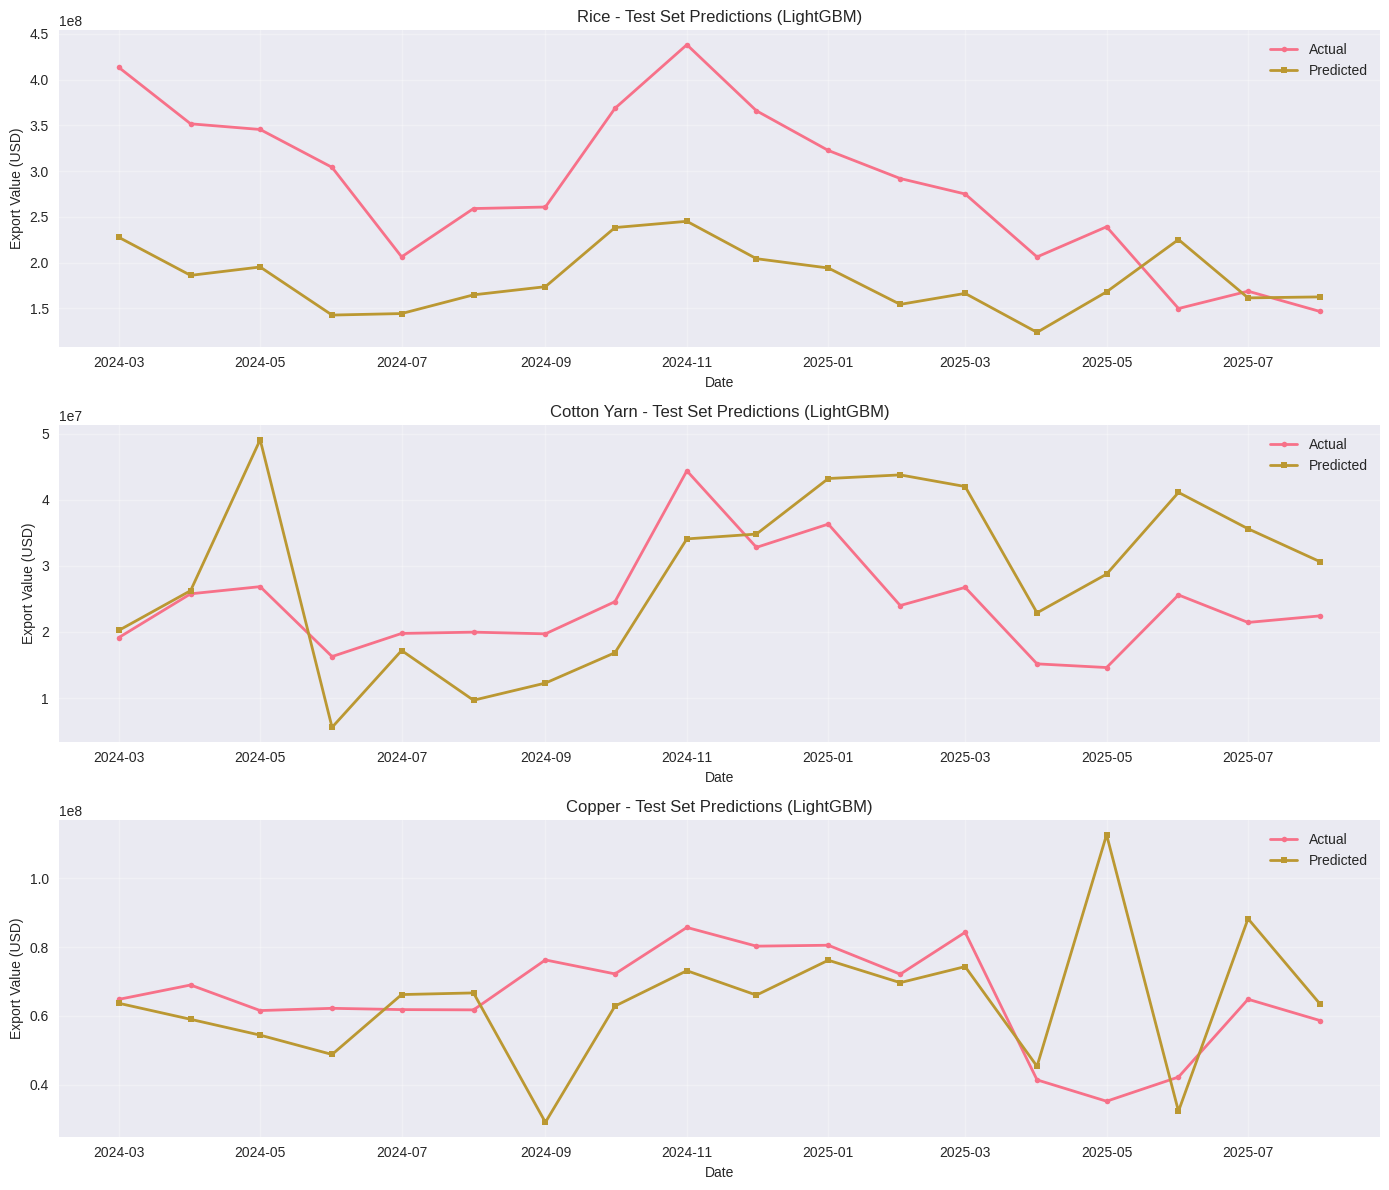

In [34]:
# Visualize test set predictions for best model
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, commodity in enumerate(commodities):
    data = test_predictions_by_commodity[commodity]
    axes[idx].plot(data['dates'], data['true'], label='Actual', linewidth=2, marker='o', markersize=4)
    axes[idx].plot(data['dates'], data['pred'], label='Predicted', linewidth=2, marker='s', markersize=4)
    axes[idx].set_title(f'{commodity} - Test Set Predictions ({best_model_name})', fontsize=12)
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Export Value (USD)', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [35]:
# Generate future dates (next 6 months from last date in dataset)
last_date = df_wide['Date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')

print(f"Last date in dataset: {last_date}")
print(f"Forecasting for next 6 months:")
for date in future_dates:
    print(f"  {date.strftime('%Y-%m-%d')}")


Last date in dataset: 2025-08-01 00:00:00
Forecasting for next 6 months:
  2025-09-01
  2025-10-01
  2025-11-01
  2025-12-01
  2026-01-01
  2026-02-01


In [36]:
# For future external regressors we'll use the last known values with forward fill
# In a real scenario you would get actual future values or use separate forecasts
last_usd_pkr = df_wide['USD_PKR'].iloc[-1]
last_oil_price = df_wide['Oil_Price'].iloc[-1]
last_us_confidence = df_wide['US_Confidence'].iloc[-1]

# Simple approach is use last known values
future_exog = pd.DataFrame({
    'Date': future_dates,
    'USD_PKR': [last_usd_pkr] * 6,
    'Oil_Price': [last_oil_price] * 6,
    'US_Confidence': [last_us_confidence] * 6
})

print("Future External Regressors (using last known values):")
print(future_exog)


Future External Regressors (using last known values):
        Date     USD_PKR  Oil_Price  US_Confidence
0 2025-09-01  281.866608  68.120003           58.2
1 2025-10-01  281.866608  68.120003           58.2
2 2025-11-01  281.866608  68.120003           58.2
3 2025-12-01  281.866608  68.120003           58.2
4 2026-01-01  281.866608  68.120003           58.2
5 2026-02-01  281.866608  68.120003           58.2


In [37]:
# Generate 6-month forecasts using best model
future_forecasts = {}

if best_model_name == 'LightGBM':
    # For advanced LightGBM we need to prepare future data with enhanced features
    # We'll create features based on last known values and forecast forward
    print("Generating 6-month forecasts using Advanced LightGBM...")

    # Get last data point for each commodity from enhanced dataset
    last_data_by_commodity = {}
    for commodity in commodities:
        commodity_data = df_lgbm_enhanced[df_lgbm_enhanced['Commodity'] == commodity].tail(1)
        last_data_by_commodity[commodity] = commodity_data

    # Generate forecasts for each commodity
    for commodity in commodities:
        commodity_forecasts = []
        last_row = last_data_by_commodity[commodity].iloc[0]

        # Create features for each future month
        for i, future_date in enumerate(future_dates):
            # Create future row with features
            future_row = last_row.copy()
            future_row['Date'] = future_date
            future_row['Year'] = future_date.year
            future_row['Month'] = future_date.month
            future_row['Quarter'] = future_date.quarter
            future_row['Month_sin'] = np.sin(2 * np.pi * future_date.month / 12)
            future_row['Month_cos'] = np.cos(2 * np.pi * future_date.month / 12)
            future_row['Quarter_sin'] = np.sin(2 * np.pi * future_date.quarter / 4)
            future_row['Quarter_cos'] = np.cos(2 * np.pi * future_date.quarter / 4)

            # Update external regressors
            future_row['USD_PKR'] = future_exog.iloc[i]['USD_PKR']
            future_row['Oil_Price'] = future_exog.iloc[i]['Oil_Price']
            future_row['US_Confidence'] = future_exog.iloc[i]['US_Confidence']

            # Update external regressor lags (use previous forecast or last known)
            if i == 0:
                future_row['USD_PKR_lag_1'] = df_wide['USD_PKR'].iloc[-1]
                future_row['Oil_Price_lag_1'] = df_wide['Oil_Price'].iloc[-1]
                future_row['US_Confidence_lag_1'] = df_wide['US_Confidence'].iloc[-1]
            else:
                future_row['USD_PKR_lag_1'] = future_exog.iloc[i-1]['USD_PKR']
                future_row['Oil_Price_lag_1'] = future_exog.iloc[i-1]['Oil_Price']
                future_row['US_Confidence_lag_1'] = future_exog.iloc[i-1]['US_Confidence']

            # For lag features of export value we'll use predictions from previous months
            # But for first prediction use last known export value
            commodity_data_enhanced = df_lgbm_enhanced[df_lgbm_enhanced['Commodity'] == commodity]
            if i == 0:
                future_row['Export_Value_USD_lag_1'] = last_row['Export_Value_USD']
                future_row['Export_Value_USD_lag_3'] = commodity_data_enhanced['Export_Value_USD'].iloc[-3] if len(commodity_data_enhanced) >= 3 else last_row['Export_Value_USD']
                future_row['Export_Value_USD_lag_6'] = commodity_data_enhanced['Export_Value_USD'].iloc[-6] if len(commodity_data_enhanced) >= 6 else last_row['Export_Value_USD']
                future_row['Export_Value_USD_lag_12'] = commodity_data_enhanced['Export_Value_USD'].iloc[-12] if len(commodity_data_enhanced) >= 12 else last_row['Export_Value_USD']
            else:
                # Use previous forecast for lag_1
                future_row['Export_Value_USD_lag_1'] = commodity_forecasts[-1]
                # For other lags use actual values if available otherwise use forecast
                if i >= 3:
                    future_row['Export_Value_USD_lag_3'] = commodity_forecasts[-3]
                else:
                    future_row['Export_Value_USD_lag_3'] = commodity_data_enhanced['Export_Value_USD'].iloc[-3+i] if len(commodity_data_enhanced) >= 3-i else last_row['Export_Value_USD']
                if i >= 6:
                    future_row['Export_Value_USD_lag_6'] = commodity_forecasts[-6]
                else:
                    future_row['Export_Value_USD_lag_6'] = commodity_data_enhanced['Export_Value_USD'].iloc[-6+i] if len(commodity_data_enhanced) >= 6-i else last_row['Export_Value_USD']
                if i >= 12:
                    future_row['Export_Value_USD_lag_12'] = commodity_forecasts[-12]
                else:
                    future_row['Export_Value_USD_lag_12'] = commodity_data_enhanced['Export_Value_USD'].iloc[-12+i] if len(commodity_data_enhanced) >= 12-i else last_row['Export_Value_USD']

            # Update interaction features
            future_row['Commodity_USD_PKR'] = future_row['Commodity_encoded'] * future_row['USD_PKR']
            future_row['Commodity_Oil'] = future_row['Commodity_encoded'] * future_row['Oil_Price']
            future_row['Commodity_Confidence'] = future_row['Commodity_encoded'] * future_row['US_Confidence']

            # Update ratio features (use lag_1 export value for ratio)
            future_row['Export_USD_PKR_ratio'] = future_row['Export_Value_USD_lag_1'] / (future_row['USD_PKR'] + 1)
            future_row['Export_Oil_ratio'] = future_row['Export_Value_USD_lag_1'] / (future_row['Oil_Price'] + 1)
            future_row['Export_Confidence_ratio'] = future_row['Export_Value_USD_lag_1'] / (future_row['US_Confidence'] + 1)

            # Update momentum features (calculate from previous forecasts)
            if i >= 3:
                future_row['Export_momentum_3'] = ((commodity_forecasts[-1] - commodity_forecasts[-3]) / (commodity_forecasts[-3] + 1)) * 100 if commodity_forecasts[-3] > 0 else 0
            else:
                if 'Export_momentum_3' in last_row.index:
                    future_row['Export_momentum_3'] = last_row['Export_momentum_3']
                else:
                    future_row['Export_momentum_3'] = 0

            if i >= 6:
                future_row['Export_momentum_6'] = ((commodity_forecasts[-1] - commodity_forecasts[-6]) / (commodity_forecasts[-6] + 1)) * 100 if commodity_forecasts[-6] > 0 else 0
            else:
                if 'Export_momentum_6' in last_row.index:
                    future_row['Export_momentum_6'] = last_row['Export_momentum_6']
                else:
                    future_row['Export_momentum_6'] = 0

            if 'Export_YoY_change' in last_row.index:
                future_row['Export_YoY_change'] = last_row['Export_YoY_change']
            else:
                future_row['Export_YoY_change'] = 0

            # Update lag_24 (use historical data if available)
            if i == 0:
                if len(commodity_data_enhanced) >= 24:
                    future_row['Export_Value_USD_lag_24'] = commodity_data_enhanced['Export_Value_USD'].iloc[-24]
                else:
                    future_row['Export_Value_USD_lag_24'] = last_row['Export_Value_USD']
            elif i >= 24:
                future_row['Export_Value_USD_lag_24'] = commodity_forecasts[-24]
            else:
                idx_needed = 24 - i
                if len(commodity_data_enhanced) >= idx_needed:
                    future_row['Export_Value_USD_lag_24'] = commodity_data_enhanced['Export_Value_USD'].iloc[-idx_needed]
                else:
                    future_row['Export_Value_USD_lag_24'] = last_row['Export_Value_USD']

            # Update trend features (use previous forecasts)
            if i >= 3:
                future_row['Export_trend_3'] = commodity_forecasts[-1] - commodity_forecasts[-3] if len(commodity_forecasts) >= 3 else 0
            else:
                if 'Export_trend_3' in last_row.index:
                    future_row['Export_trend_3'] = last_row['Export_trend_3']
                else:
                    future_row['Export_trend_3'] = 0

            if i >= 6:
                future_row['Export_trend_6'] = commodity_forecasts[-1] - commodity_forecasts[-6] if len(commodity_forecasts) >= 6 else 0
            else:
                if 'Export_trend_6' in last_row.index:
                    future_row['Export_trend_6'] = last_row['Export_trend_6']
                else:
                    future_row['Export_trend_6'] = 0

            # Update acceleration (change in trend)
            if i >= 1:
                prev_trend = commodity_forecasts[-1] - commodity_forecasts[-2] if len(commodity_forecasts) >= 2 else 0
                if i >= 2:
                    prev_prev_trend = commodity_forecasts[-2] - commodity_forecasts[-3] if len(commodity_forecasts) >= 3 else 0
                    future_row['Export_acceleration'] = prev_trend - prev_prev_trend
                else:
                    future_row['Export_acceleration'] = 0
            else:
                if 'Export_acceleration' in last_row.index:
                    future_row['Export_acceleration'] = last_row['Export_acceleration']
                else:
                    future_row['Export_acceleration'] = 0

            # Update volatility features (use rolling std of recent forecasts and historical data)
            if i >= 3:
                recent_values = commodity_forecasts[-3:] if len(commodity_forecasts) >= 3 else commodity_forecasts
                future_row['Export_volatility_3'] = np.std(recent_values) if len(recent_values) > 1 else 0
            else:
                if 'Export_volatility_3' in last_row.index:
                    future_row['Export_volatility_3'] = last_row['Export_volatility_3']
                else:
                    future_row['Export_volatility_3'] = 0

            if i >= 6:
                recent_values = commodity_forecasts[-6:] if len(commodity_forecasts) >= 6 else commodity_forecasts
                future_row['Export_volatility_6'] = np.std(recent_values) if len(recent_values) > 1 else 0
            else:
                if 'Export_volatility_6' in last_row.index:
                    future_row['Export_volatility_6'] = last_row['Export_volatility_6']
                else:
                    future_row['Export_volatility_6'] = 0

            # Update external driver change features (calculate 3-month change)
            if i >= 3:
                usd_pkr_3_months_ago = future_exog.iloc[i-3]['USD_PKR'] if i >= 3 else df_wide['USD_PKR'].iloc[-1]
                oil_3_months_ago = future_exog.iloc[i-3]['Oil_Price'] if i >= 3 else df_wide['Oil_Price'].iloc[-1]
                conf_3_months_ago = future_exog.iloc[i-3]['US_Confidence'] if i >= 3 else df_wide['US_Confidence'].iloc[-1]

                future_row['USD_PKR_change_3'] = ((future_row['USD_PKR'] - usd_pkr_3_months_ago) / (usd_pkr_3_months_ago + 1)) * 100
                future_row['Oil_Price_change_3'] = ((future_row['Oil_Price'] - oil_3_months_ago) / (oil_3_months_ago + 1)) * 100
                future_row['US_Confidence_change_3'] = ((future_row['US_Confidence'] - conf_3_months_ago) / (conf_3_months_ago + 1)) * 100
            else:
                # Use historical data to calculate 3-month change
                if len(df_wide) >= (3 - i):
                    usd_pkr_3_ago = df_wide['USD_PKR'].iloc[-(3-i)] if (3-i) <= len(df_wide) else df_wide['USD_PKR'].iloc[-1]
                    oil_3_ago = df_wide['Oil_Price'].iloc[-(3-i)] if (3-i) <= len(df_wide) else df_wide['Oil_Price'].iloc[-1]
                    conf_3_ago = df_wide['US_Confidence'].iloc[-(3-i)] if (3-i) <= len(df_wide) else df_wide['US_Confidence'].iloc[-1]

                    future_row['USD_PKR_change_3'] = ((future_row['USD_PKR'] - usd_pkr_3_ago) / (usd_pkr_3_ago + 1)) * 100
                    future_row['Oil_Price_change_3'] = ((future_row['Oil_Price'] - oil_3_ago) / (oil_3_ago + 1)) * 100
                    future_row['US_Confidence_change_3'] = ((future_row['US_Confidence'] - conf_3_ago) / (conf_3_ago + 1)) * 100
                else:
                    if 'USD_PKR_change_3' in last_row.index:
                        future_row['USD_PKR_change_3'] = last_row['USD_PKR_change_3']
                        future_row['Oil_Price_change_3'] = last_row['Oil_Price_change_3']
                        future_row['US_Confidence_change_3'] = last_row['US_Confidence_change_3']
                    else:
                        future_row['USD_PKR_change_3'] = 0
                        future_row['Oil_Price_change_3'] = 0
                        future_row['US_Confidence_change_3'] = 0

            # Update interaction features with lags
            future_row['Lag1_USD_PKR'] = future_row['Export_Value_USD_lag_1'] * future_row['USD_PKR']
            future_row['Lag1_Oil'] = future_row['Export_Value_USD_lag_1'] * future_row['Oil_Price']
            future_row['Lag1_Confidence'] = future_row['Export_Value_USD_lag_1'] * future_row['US_Confidence']

            # Update commodity-seasonality interactions
            future_row['Commodity_Month'] = future_row['Commodity_encoded'] * future_row['Month_sin']
            future_row['Commodity_Quarter'] = future_row['Commodity_encoded'] * future_row['Quarter_sin']

            # Update polynomial features
            future_row['USD_PKR_squared'] = future_row['USD_PKR'] ** 2
            future_row['Oil_Price_squared'] = future_row['Oil_Price'] ** 2

            # Update percentile features (use last known percentile)
            if 'Export_percentile_12' in last_row.index:
                future_row['Export_percentile_12'] = last_row['Export_percentile_12']
            else:
                future_row['Export_percentile_12'] = 0.5

            # Update lag vs rolling mean features
            rolling_mean_6 = future_row.get('Export_Value_USD_rolling_mean_6', future_row['Export_Value_USD_lag_1']) if 'Export_Value_USD_rolling_mean_6' in future_row.index else future_row['Export_Value_USD_lag_1']
            rolling_mean_12 = future_row.get('Export_Value_USD_rolling_mean_12', future_row['Export_Value_USD_lag_1']) if 'Export_Value_USD_rolling_mean_12' in future_row.index else future_row['Export_Value_USD_lag_1']

            future_row['Lag1_vs_rolling_mean_6'] = (future_row['Export_Value_USD_lag_1'] - rolling_mean_6) / (rolling_mean_6 + 1)
            future_row['Lag1_vs_rolling_mean_12'] = (future_row['Export_Value_USD_lag_1'] - rolling_mean_12) / (rolling_mean_12 + 1)

            # Fill rolling features with last known values (simplified approach)
            if 'Export_Value_USD_rolling_mean_3' in last_row.index:
                future_row['Export_Value_USD_rolling_mean_3'] = last_row['Export_Value_USD_rolling_mean_3']
            else:
                future_row['Export_Value_USD_rolling_mean_3'] = last_row['Export_Value_USD']

            if 'Export_Value_USD_rolling_mean_6' in last_row.index:
                future_row['Export_Value_USD_rolling_mean_6'] = last_row['Export_Value_USD_rolling_mean_6']
            else:
                future_row['Export_Value_USD_rolling_mean_6'] = last_row['Export_Value_USD']

            if 'Export_Value_USD_rolling_mean_12' in last_row.index:
                future_row['Export_Value_USD_rolling_mean_12'] = last_row['Export_Value_USD_rolling_mean_12']
            else:
                future_row['Export_Value_USD_rolling_mean_12'] = last_row['Export_Value_USD']

            if 'Export_Value_USD_rolling_std_3' in last_row.index:
                future_row['Export_Value_USD_rolling_std_3'] = last_row['Export_Value_USD_rolling_std_3']
            else:
                future_row['Export_Value_USD_rolling_std_3'] = 0

            if 'Export_Value_USD_rolling_std_6' in last_row.index:
                future_row['Export_Value_USD_rolling_std_6'] = last_row['Export_Value_USD_rolling_std_6']
            else:
                future_row['Export_Value_USD_rolling_std_6'] = 0

            if 'Export_Value_USD_rolling_std_12' in last_row.index:
                future_row['Export_Value_USD_rolling_std_12'] = last_row['Export_Value_USD_rolling_std_12']
            else:
                future_row['Export_Value_USD_rolling_std_12'] = 0

            # Prepare feature vector with enhanced features
            # Ensure all enhanced features are present
            X_future_row = []
            for col in feature_cols_enhanced:
                if col in future_row.index:
                    X_future_row.append(future_row[col])
                else:
                    X_future_row.append(0)  # Default to 0 if feature missing

            X_future = np.array(X_future_row).reshape(1, -1)

            # Make prediction (model outputs log-transformed value)
            forecast_value_log = model_lgbm.predict(X_future, num_iteration=model_lgbm.best_iteration)[0]
            forecast_value = np.expm1(forecast_value_log)  # Inverse log transformation
            forecast_value = max(0, forecast_value)  # Ensure non-negative
            commodity_forecasts.append(forecast_value)

        future_forecasts[commodity] = commodity_forecasts

elif best_model_name == 'Prophet':
    print("Generating 6-month forecasts using Prophet...")

    for commodity in commodities:
        # Create future dataframe with future dates
        future = pd.DataFrame({'ds': future_dates})
        future['USD_PKR'] = future_exog['USD_PKR'].values
        future['Oil_Price'] = future_exog['Oil_Price'].values
        future['US_Confidence'] = future_exog['US_Confidence'].values

        # Make forecast
        forecast = models_prophet[commodity].predict(future)
        future_forecasts[commodity] = forecast['yhat'].values

else:  # SARIMAX
    print("Generating 6-month forecasts using SARIMAX...")

    for commodity in commodities:
        # Prepare future external regressors
        future_exog_values = future_exog[['USD_PKR', 'Oil_Price', 'US_Confidence']].values

        # Make forecast using auto_arima model
        forecast = models_sarimax[commodity].predict(n_periods=6, exogenous=future_exog_values)
        # Convert to numpy array if needed
        if hasattr(forecast, 'values'):
            future_forecasts[commodity] = forecast.values
        else:
            future_forecasts[commodity] = np.array(forecast)

print("\n6-month forecasts generated successfully")


Generating 6-month forecasts using Advanced LightGBM...

6-month forecasts generated successfully


In [38]:
# Create forecast results dataframe
forecast_results = []

for commodity in commodities:
    for i, date in enumerate(future_dates):
        forecast_results.append({
            'Date': date,
            'Commodity': commodity,
            'Forecast_Export_Value_USD': future_forecasts[commodity][i]
        })

forecast_df = pd.DataFrame(forecast_results)
forecast_df = forecast_df.sort_values(['Date', 'Commodity']).reset_index(drop=True)

print("6-Month Forecast Results:")
print(forecast_df)


6-Month Forecast Results:
         Date    Commodity  Forecast_Export_Value_USD
0  2025-09-01       Copper               7.008868e+07
1  2025-09-01  Cotton Yarn               3.470536e+07
2  2025-09-01         Rice               1.284825e+08
3  2025-10-01       Copper               6.547025e+07
4  2025-10-01  Cotton Yarn               3.508249e+07
5  2025-10-01         Rice               1.207030e+08
6  2025-11-01       Copper               6.669359e+07
7  2025-11-01  Cotton Yarn               3.624703e+07
8  2025-11-01         Rice               1.266690e+08
9  2025-12-01       Copper               5.995665e+07
10 2025-12-01  Cotton Yarn               3.749685e+07
11 2025-12-01         Rice               1.467713e+08
12 2026-01-01       Copper               6.376774e+07
13 2026-01-01  Cotton Yarn               4.045725e+07
14 2026-01-01         Rice               1.570794e+08
15 2026-02-01       Copper               6.168163e+07
16 2026-02-01  Cotton Yarn               3.851241e+07
17

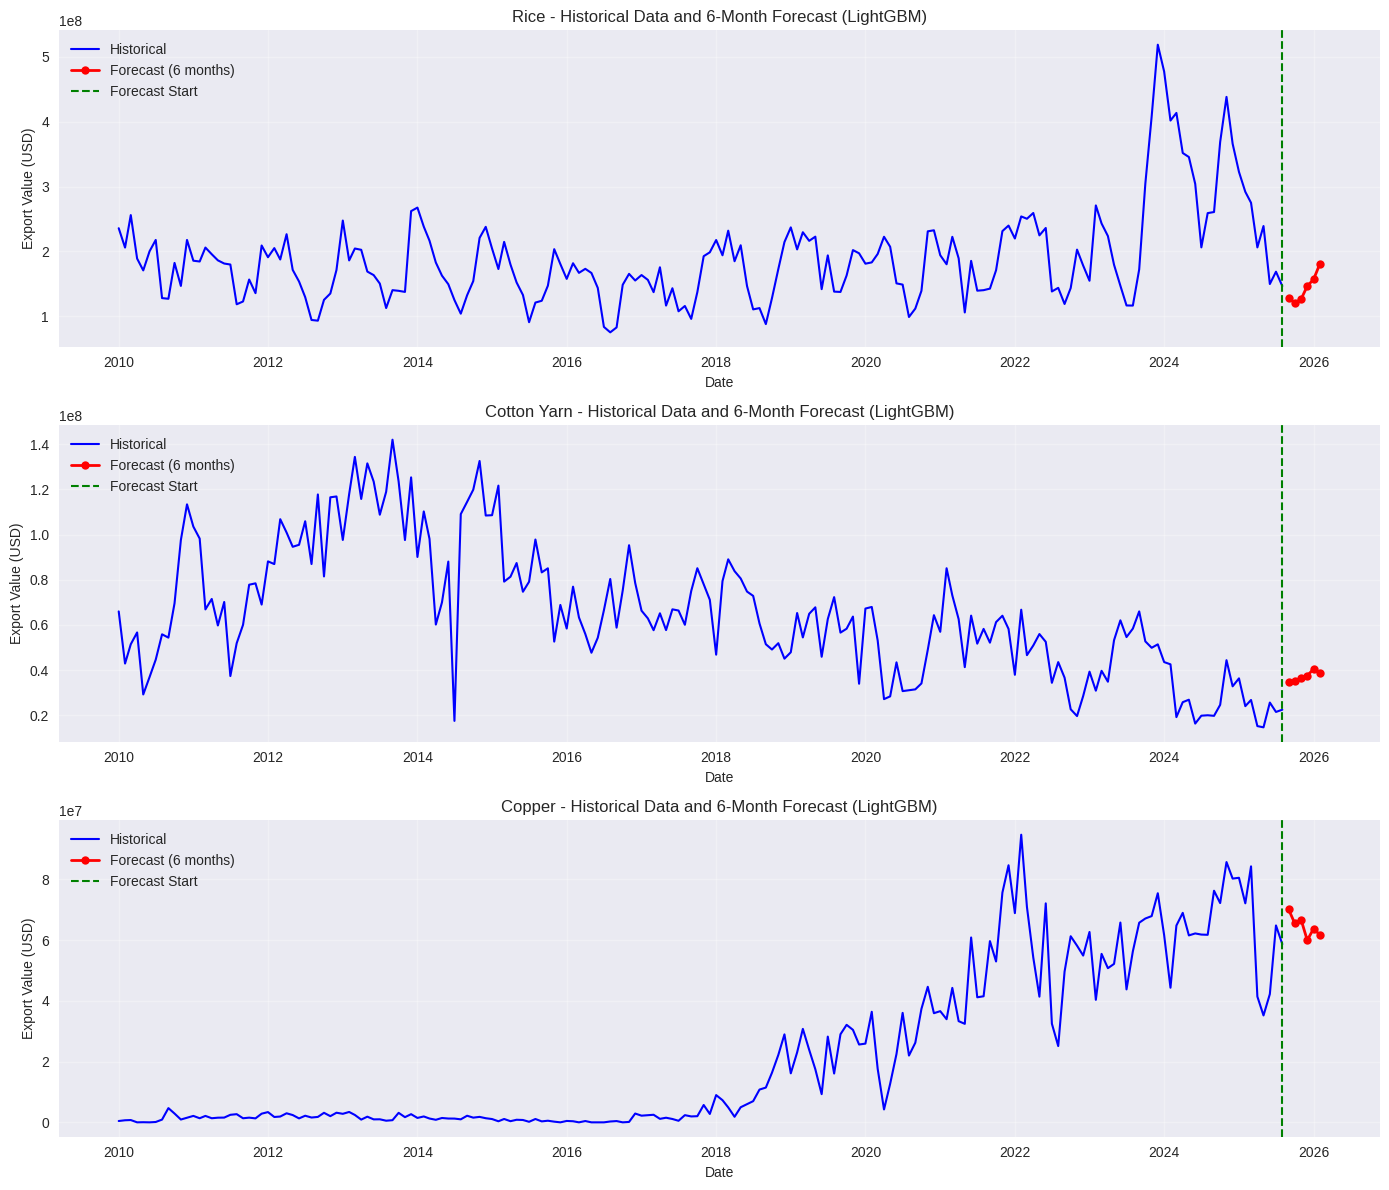

In [39]:
# Visualize future forecasts along with historical data
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

for idx, commodity in enumerate(commodities):
    # Plot historical data
    historical = df_long[df_long['Commodity'] == commodity]
    axes[idx].plot(historical['Date'], historical['Export_Value_USD'], label='Historical', linewidth=1.5, color='blue')

    # Plot forecasts
    commodity_forecast = forecast_df[forecast_df['Commodity'] == commodity]
    axes[idx].plot(commodity_forecast['Date'], commodity_forecast['Forecast_Export_Value_USD'],
                   label='Forecast (6 months)', linewidth=2, marker='o', markersize=6, color='red')

    axes[idx].axvline(x=last_date, color='green', linestyle='--', linewidth=1.5, label='Forecast Start')
    axes[idx].set_title(f'{commodity} - Historical Data and 6-Month Forecast ({best_model_name})', fontsize=12)
    axes[idx].set_xlabel('Date', fontsize=10)
    axes[idx].set_ylabel('Export Value (USD)', fontsize=10)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:
# Save forecast results to CSV
os.makedirs('forecasts', exist_ok=True)
forecast_output_path = 'forecasts/future_forecasts_6months.csv'
forecast_df.to_csv(forecast_output_path, index=False)
print(f"Forecast results saved to: {forecast_output_path}")


Forecast results saved to: forecasts/future_forecasts_6months.csv


## Section 12: Model Persistence

Save the best model and related files for use in the web dashboard.


In [41]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save best model
if best_model_name == 'LightGBM':
    model_path = 'models/best_model_lgbm.pkl'
    joblib.dump(model_lgbm, model_path)
    print(f"Improved LightGBM model saved to: {model_path}")

    # Also save enhanced feature names
    feature_names_path = 'models/feature_names_lgbm.json'
    with open(feature_names_path, 'w') as f:
        json.dump(feature_cols_enhanced, f)
    print(f"Enhanced feature names saved to: {feature_names_path}")

elif best_model_name == 'Prophet':
    # Save all three Prophet models
    for commodity in commodities:
        model_path = f'models/best_model_prophet_{commodity.replace(" ", "_").lower()}.pkl'
        joblib.dump(models_prophet[commodity], model_path)
        print(f"Prophet model for {commodity} saved to: {model_path}")

else:  # SARIMAX
    # Save all three SARIMAX models
    for commodity in commodities:
        model_path = f'models/best_model_sarimax_{commodity.replace(" ", "_").lower()}.pkl'
        joblib.dump(models_sarimax[commodity], model_path)
        print(f"SARIMAX model for {commodity} saved to: {model_path}")


Improved LightGBM model saved to: models/best_model_lgbm.pkl
Enhanced feature names saved to: models/feature_names_lgbm.json


In [42]:
# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': best_model_name,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_set_metrics': {
        'MAE': float(mae_test),
        'RMSE': float(rmse_test),
        'MAPE': float(mape_test),
        'R2': float(r2_test)
    },
    'validation_set_metrics': {
        'MAE': float(mae_lgbm_val if best_model_name == 'LightGBM' else avg_mae_prophet if best_model_name == 'Prophet' else avg_mae_sarimax),
        'RMSE': float(rmse_lgbm_val if best_model_name == 'LightGBM' else avg_rmse_prophet if best_model_name == 'Prophet' else avg_rmse_sarimax),
        'MAPE': float(mape_lgbm_val if best_model_name == 'LightGBM' else avg_mape_prophet if best_model_name == 'Prophet' else avg_mape_sarimax),
        'R2': float(r2_lgbm_val if best_model_name == 'LightGBM' else avg_r2_prophet if best_model_name == 'Prophet' else avg_r2_sarimax)
    },
    'commodities': commodities,
    'forecast_horizon': 6,
    'data_range': {
        'start': str(df_long['Date'].min()),
        'end': str(df_long['Date'].max())
    }
}

metadata_path = 'models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"Model metadata saved to: {metadata_path}")
print("\nModel metadata:")
print(json.dumps(metadata, indent=2))


Model metadata saved to: models/model_metadata.json

Model metadata:
{
  "model_name": "LightGBM",
  "model_type": "LightGBM",
  "training_date": "2026-01-11 13:53:44",
  "test_set_metrics": {
    "MAE": 45447690.70489704,
    "RMSE": 73066389.0843689,
    "MAPE": 36.129473290140915,
    "R2": 0.6557802633590692
  },
  "validation_set_metrics": {
    "MAE": 21784069.823192798,
    "RMSE": 45290186.51066114,
    "MAPE": 16.742610004044515,
    "R2": 0.8425597027149944
  },
  "commodities": [
    "Rice",
    "Cotton Yarn",
    "Copper"
  ],
  "forecast_horizon": 6,
  "data_range": {
    "start": "2010-01-01 00:00:00",
    "end": "2025-08-01 00:00:00"
  }
}


## Summary

This notebook has completed the forecasting pipeline:

1. Loaded and explored the dataset
2. Created features for all models
3. Trained three models: LightGBM, Prophet, and SARIMAX
4. Compared models and selected the best performing model
5. Evaluated best model on test set
6. Generated 6-month future forecasts
7. Saved the best model and metadata for dashboard integration

The best model has been selected based on MAPE (Mean Absolute Percentage Error) on the validation set.

The model has been saved and is ready to be integrated into the web dashboard.
